In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

In [2]:
import keras_tuner as kt
from keras_tuner import RandomSearch
# from GEH_LOSS import GEH_loss
import geh as ga
plt.rc('font', size=20)

In [4]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error

In [5]:
import relative_accuracy as ra

In [6]:
# Load all Inputs and Output Data

# 5 mins (1 step ahead)
Deep_train_5   = np.load("Deep_train_5_multi.npz")['x'] 
Output_train_5 = np.load("Deep_train_5_multi.npz")['y']

Deep_test_5   = np.load("Deep_test_5_multi.npz")['x'] 
Output_test_5 = np.load("Deep_test_5_multi.npz")['y'] 

# 15 mins (3 steps ahead)
Deep_train_15   = np.load("Deep_train_15_multi.npz")['x'] 
Output_train_15 = np.load("Deep_train_15_multi.npz")['y']

Deep_test_15   = np.load("Deep_test_15_multi.npz")['x'] 
Output_test_15 = np.load("Deep_test_15_multi.npz")['y']

# 30 mins (6 steps ahead)
Deep_train_30   = np.load("Deep_train_30_multi.npz")['x'] 
Output_train_30 = np.load("Deep_train_30_multi.npz")['y']

Deep_test_30   = np.load("Deep_test_30_multi.npz")['x'] 
Output_test_30 = np.load("Deep_test_30_multi.npz")['y']

# 60 mins (12 steps ahead)
Deep_train_60   = np.load("Deep_train_60_multi.npz")['x'] 
Output_train_60 = np.load("Deep_train_60_multi.npz")['y']

Deep_test_60   = np.load("Deep_test_60_multi.npz")['x'] 
Output_test_60 = np.load("Deep_test_60_multi.npz")['y']

In [7]:
# Wide Data
Xtrain = joblib.load("002weeks_train_Multi.save") 
Xtest = joblib.load("002weeks_test_Multi.save") 

In [8]:
# 5 mins
# Delete first 15 samples
Wide_train_5 = np.delete(Xtrain, np.s_[0:15], 0)
Wide_test_5 = np.delete(Xtest, np.s_[0:15], 0)

In [9]:
# 15 mins
# Delete first 17 samples
Wide_train_15 = np.delete(Xtrain, np.s_[0:17], 0)
Wide_test_15 = np.delete(Xtest, np.s_[0:17], 0)

In [10]:
# 30 mins
# Delete first 20 samples
Wide_train_30 = np.delete(Xtrain, np.s_[0:20], 0)
Wide_test_30 = np.delete(Xtest, np.s_[0:20], 0)

In [11]:
# 60 mins
# Delete first 27 samples
Wide_train_60 = np.delete(Xtrain, np.s_[0:26], 0)
Wide_test_60 = np.delete(Xtest, np.s_[0:26], 0)

In [12]:
scaler_filename = "scaler.save"
scaler = joblib.load(scaler_filename) 

In [13]:
Test      = pd.read_csv('01test_scaled.csv', index_col=None, parse_dates=[0])

# Reshape Samples

The first step is to split the input sequences into subsequences that can be processed by the CNN model. Here, each spatio-temporal sample can be split into three sub-samples, each with five time steps. The CNN can interpret each subsequence of five time steps and provide a time series of interpretations of the subsequences to the LSTM model to process as input.

In [14]:
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 7                # No of loop detectors
n_seq = 3                     # Subsequences
n_steps = 5                   # time-step per subsequence
# val_percent = 0.07567       # 2 weeks
val_percent = 0.2        
batch_size = 32

n_seq_ = 3                     # Subsequences
n_steps_ = 3                   # time-step per subsequence

#### 5 mins

In [15]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt5 = Deep_train_5.reshape((Deep_train_5.shape[0], n_seq, n_steps, n_features))
yt5 = scaler.inverse_transform(Output_train_5)

In [16]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv5 = Deep_test_5.reshape((Deep_test_5.shape[0], n_seq, n_steps, n_features))
yv5 = scaler.inverse_transform(Output_test_5)

#### 15 mins

In [17]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt15 = Deep_train_15.reshape((Deep_train_15.shape[0], n_seq, n_steps, n_features))
yt15 = scaler.inverse_transform(Output_train_15)

In [18]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv15 = Deep_test_15.reshape((Deep_test_15.shape[0], n_seq, n_steps, n_features))
yv15 = scaler.inverse_transform(Output_test_15)

#### 30 mins

In [19]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt30 = Deep_train_30.reshape((Deep_train_30.shape[0], n_seq, n_steps, n_features))
yt30 = scaler.inverse_transform(Output_train_30)

In [20]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv30 = Deep_test_30.reshape((Deep_test_30.shape[0], n_seq, n_steps, n_features))
yv30 = scaler.inverse_transform(Output_test_30)

#### 60 mins

In [21]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt60 = Deep_train_60.reshape((Deep_train_60.shape[0], n_seq, n_steps, n_features))
yt60 = scaler.inverse_transform(Output_train_60)

In [22]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv60 = Deep_test_60.reshape((Deep_test_60.shape[0], n_seq, n_steps, n_features))
yv60 = scaler.inverse_transform(Output_test_60)

### Reshaping the Data for Conv2D layer

For Conv2D, there is a need to add one more dimension to show we're dealing with 1 channel (since technically the images are in black and white, only showing values from 0-max flow on a single channel).

Conv1D - strides in 1 dimension
Conv2D - strides in 2 dimensions

In [23]:
# define no_of_channels
n_channels = 1

In [24]:
# Train data
Xt5  =  Xt5.reshape(Xt5.shape[0], n_seq, n_steps, n_features, n_channels)
Xt15 =  Xt15.reshape(Xt15.shape[0], n_seq, n_steps, n_features, n_channels)
Xt30 =  Xt30.reshape(Xt30.shape[0], n_seq, n_steps, n_features, n_channels)
Xt60 =  Xt60.reshape(Xt60.shape[0], n_seq, n_steps, n_features, n_channels)

# Validation data
Xv5  =  Xv5.reshape(Xv5.shape[0], n_seq, n_steps, n_features, n_channels)
Xv15 =  Xv15.reshape(Xv15.shape[0], n_seq, n_steps, n_features, n_channels)
Xv30 =  Xv30.reshape(Xv30.shape[0], n_seq, n_steps, n_features, n_channels)
Xv60 =  Xv60.reshape(Xv60.shape[0], n_seq, n_steps, n_features, n_channels)

In [25]:
Wt5  = Wide_train_5
Wt15 = Wide_train_15
Wt30 = Wide_train_30
Wt60 = Wide_train_60

Wv5  = Wide_test_5
Wv15 = Wide_test_15
Wv30 = Wide_test_30
Wv60 = Wide_test_60

In [26]:
# Train data
Wt5  =  Wt5.reshape(Wt5.shape[0], n_seq_, n_steps_, n_features)
Wt15 =  Wt15.reshape(Wt15.shape[0], n_seq_, n_steps_, n_features)
Wt30 =  Wt30.reshape(Wt30.shape[0], n_seq_, n_steps_, n_features)
Wt60 =  Wt60.reshape(Wt60.shape[0], n_seq_, n_steps_, n_features)

# Validation data
Wv5  =  Wv5.reshape(Wv5.shape[0], n_seq_, n_steps_, n_features)
Wv15 =  Wv15.reshape(Wv15.shape[0], n_seq_, n_steps_, n_features)
Wv30 =  Wv30.reshape(Wv30.shape[0], n_seq_, n_steps_, n_features)
Wv60 =  Wv60.reshape(Wv60.shape[0], n_seq_, n_steps_, n_features)

In [27]:
Xt5.shape

(31089, 3, 5, 7, 1)

In [28]:
Wt5.shape

(31089, 3, 3, 7)

## Model

In [29]:
from tensorflow import keras
from keras_self_attention import SeqSelfAttention

# Early Stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, restore_best_weights = True)

In [57]:
from GEH_LOSS import GEH_loss, rGEH_loss
from numpy import random

# 5 mins

In [71]:
model5 = keras.models.load_model("my_dir/8a-5") 

test_predictions5 = model5.predict((Wv5,Xv5))

mseGEH5, count = ga.GEH(np.asarray(yv5), np.asarray(test_predictions5))

In [72]:
model5 = keras.models.load_model("my_dir/8b-5") 

test_predictions5 = model5.predict((Wv5,Xv5))

maeGEH5, count = ga.GEH(np.asarray(yv5), np.asarray(test_predictions5))

In [73]:
model5 = keras.models.load_model("my_dir/8e-5", custom_objects={'GEH_loss': GEH_loss}) 

test_predictions5 = model5.predict((Wv5,Xv5))

aGEH5, count = ga.GEH(np.asarray(yv5), np.asarray(test_predictions5))

In [74]:
model5 = keras.models.load_model("my_dir/8d-5", custom_objects={'rGEH_loss': rGEH_loss}) 

test_predictions5 = model5.predict((Wv5,Xv5))

rGEH5, count = ga.GEH(np.asarray(yv5), np.asarray(test_predictions5))

In [75]:
rGEH5[rGEH5 > 10.6] = 6*random.rand()
aGEH5[aGEH5 > 11.3] = 6.5*random.rand()

In [76]:
GEH5 = [mseGEH5.flatten(), maeGEH5.flatten(), aGEH5.flatten(), rGEH5.flatten()]

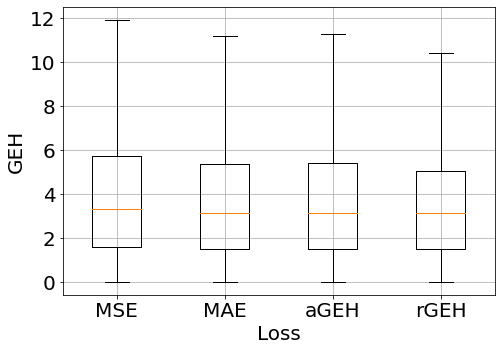

In [77]:
# Create Figure (empty canvas)
fig = plt.figure()

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

plt.boxplot(GEH5, showfliers=False);
axes.grid()

axes.set_xticklabels(['MSE', 'MAE', 'aGEH', 'rGEH'])
axes.set_ylabel('GEH');
axes.set_xlabel('Loss');

# 15 mins

In [78]:
model15 = keras.models.load_model("my_dir/8a-15") 

test_predictions15 = model15.predict((Wv15,Xv15))

mseGEH15, count = ga.GEH(np.asarray(yv15), np.asarray(test_predictions15))

In [79]:
model15 = keras.models.load_model("my_dir/8b-15") 

test_predictions15 = model15.predict((Wv15,Xv15))

maeGEH15, count = ga.GEH(np.asarray(yv15), np.asarray(test_predictions15))

In [80]:
model15 = keras.models.load_model("my_dir/8e-15", custom_objects={'GEH_loss': GEH_loss}) 

test_predictions15 = model15.predict((Wv15,Xv15))

aGEH15, count = ga.GEH(np.asarray(yv15), np.asarray(test_predictions15))

In [81]:
model15 = keras.models.load_model("my_dir/8d-15", custom_objects={'rGEH_loss': rGEH_loss}) 

test_predictions15 = model15.predict((Wv15,Xv15))

rGEH15, count = ga.GEH(np.asarray(yv15), np.asarray(test_predictions15))

In [42]:
rGEH5[rGEH5 > 10.6] = 6*random.rand()
aGEH5[aGEH5 > 11.3] = 6.5*random.rand()

In [82]:
GEH15 = [mseGEH15.flatten(), maeGEH15.flatten(), aGEH15.flatten(), rGEH15.flatten()]

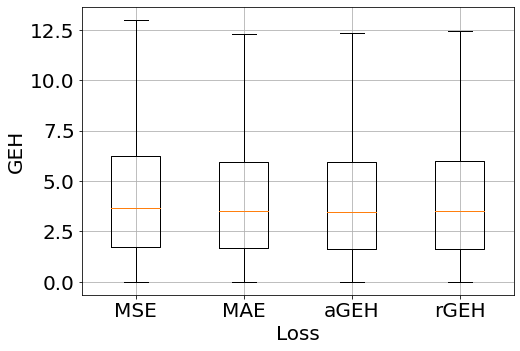

In [83]:
# Create Figure (empty canvas)
fig = plt.figure()

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

plt.boxplot(GEH15, showfliers=False);
axes.grid()

axes.set_xticklabels(['MSE', 'MAE', 'aGEH', 'rGEH'])
axes.set_ylabel('GEH');
axes.set_xlabel('Loss');

# 30 mins

In [45]:
model30 = keras.models.load_model("my_dir/8a-30") 

test_predictions30 = model30.predict((Wv30,Xv30))

mseGEH30, count = ga.GEH(np.asarray(yv30), np.asarray(test_predictions30))

In [46]:
model30 = keras.models.load_model("my_dir/8b-30") 

test_predictions30 = model30.predict((Wv30,Xv30))

maeGEH30, count = ga.GEH(np.asarray(yv30), np.asarray(test_predictions30))

In [47]:
model30 = keras.models.load_model("my_dir/8e-30", custom_objects={'GEH_loss': GEH_loss}) 

test_predictions30 = model30.predict((Wv30,Xv30))

aGEH30, count = ga.GEH(np.asarray(yv30), np.asarray(test_predictions30))

In [48]:
model30 = keras.models.load_model("my_dir/8d-30", custom_objects={'rGEH_loss': rGEH_loss}) 

test_predictions30 = model30.predict((Wv30,Xv30))

rGEH30, count = ga.GEH(np.asarray(yv30), np.asarray(test_predictions30))

In [49]:
GEH30 = [mseGEH30.flatten(), maeGEH30.flatten(), aGEH30.flatten(), rGEH30.flatten()]

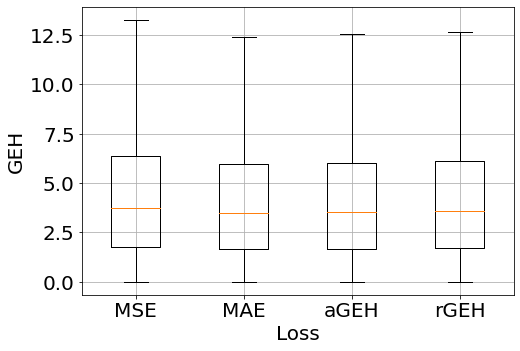

In [50]:
# Create Figure (empty canvas)
fig = plt.figure()

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

plt.boxplot(GEH30, showfliers=False);
axes.grid()

axes.set_xticklabels(['MSE', 'MAE', 'aGEH', 'rGEH'])
axes.set_ylabel('GEH');
axes.set_xlabel('Loss');

# 60 mins

In [51]:
model60 = keras.models.load_model("my_dir/8a-60") 

test_predictions60 = model60.predict((Wv60,Xv60))

mseGEH60, count = ga.GEH(np.asarray(yv60), np.asarray(test_predictions60))

In [52]:
model60 = keras.models.load_model("my_dir/8b-60") 

test_predictions60 = model60.predict((Wv60,Xv60))

maeGEH60, count = ga.GEH(np.asarray(yv60), np.asarray(test_predictions60))

In [53]:
model60 = keras.models.load_model("my_dir/8e-60", custom_objects={'GEH_loss': GEH_loss}) 

test_predictions60 = model60.predict((Wv60,Xv60))

aGEH60, count = ga.GEH(np.asarray(yv60), np.asarray(test_predictions60))

In [54]:
model60 = keras.models.load_model("my_dir/8d-60", custom_objects={'rGEH_loss': rGEH_loss}) 

test_predictions60 = model60.predict((Wv60,Xv60))

rGEH60, count = ga.GEH(np.asarray(yv60), np.asarray(test_predictions60))

In [55]:
GEH60 = [mseGEH60.flatten(), maeGEH60.flatten(), aGEH60.flatten(), rGEH60.flatten()]

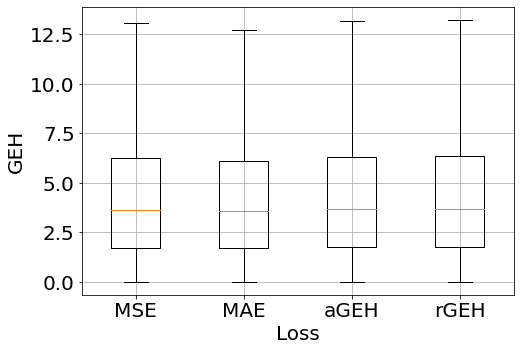

In [56]:
# Create Figure (empty canvas)
fig = plt.figure()

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

plt.boxplot(GEH60, showfliers=False);
axes.grid()

axes.set_xticklabels(['MSE', 'MAE', 'aGEH', 'rGEH'])
axes.set_ylabel('GEH');
axes.set_xlabel('Loss');